# "Ranking learning"

- toc: false
- comments: true
- hide: true
- search_exclude: true

So we have some kind of reading club at our company where we normally share papers that we find interesting, so one of us has to explain the paper to the rest. 
This is week was my turn and since we had lately been talking about recommendation I thought on looking for a paper on Ranking. But instead of finding a SOA paper,
I thought it might be interesting to go into the roots and start simple since I hadnt touched much about this topic before. I finally decided to talk about the 
paper by Microsoft named "" wchich is not precisely new. Once I started reading it some references to previous work pop out as expected but there was a common term in 
all of them, a more basic concept named Ordinal Regression. So I decided to read about this and explain this concept before commenting on the paper. So I am gonna 
recreate my talk here starting from Ordinal Regression and touching later on Ranking as explained in the Microsoft paper. 

So to clarify, Ordinal regression is actually the same as Ranking Learning only that the latter is used in the machine learning field. The authors in the paper mention Ordinal Regression itself as a model and I think what they really refer to is the generalized linear model that I will present next (actually Wikipedia will).

Wikipedia has a nice entry on this topic so I am just going to copy the relevant parts and comment them when needed:

## Linear models for ordinal regression
Ordinal regression can be performed using a generalized linear model (GLM) that fits both a coefficient vector and a set of thresholds to a dataset. Suppose one has a set of observations, represented by length-p vectors $\small x_1$ through $\small x_n$, with associated responses $\small y_1$ through $\small y_n$, where each $\small y_i$ is an ordinal variable on a scale $\small 1, ..., K$. For simplicity, and without loss of generality, we assume $\small y$ is a non-decreasing vector, that is, $\small y_i \leq y_{i+1}$. To this data, one fits a length-p coefficient vector $\small \bf w$ and a set of thresholds $\small \theta_1, ..., \theta_{K−1}$ with the property that $\small θ1 < \theta_2 < ... < \theta_{K−1}$. This set of thresholds divides the real number line into $\small K$ disjoint segments, corresponding to the $\small K$ response levels.
The model can now be formulated as 
$$
Pr(y\leq i|\bf{x}) = \sigma(\theta_i - \bf{w \cdot x})
$$

There are different options for the $\small\sigma$ function (inverse link funciton in GLM language) which is our cummulative distribution function, and I am going to mention two:
- logistic function
- probit function

When we use the logistic function we assume that our error term follows a logistic distribution with $\small \mu = 0$ and $s = 0$ (scale parameter) conditioned on $\small \bf{x}$ and when we use the probit function we assume our error term follows a normal distribution with $\small \mu = 0$ and $\small \sigma = 0$ conditioned on $\small \bf{x}$. Both distributions have a similar shape but the logistic distribution has heavier tails, hence being more robust.

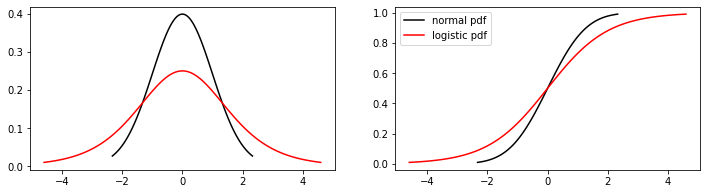

In [103]:
import numpy as np
from scipy.stats import norm, logistic

import matplotlib.pyplot as plt

loc = 0
scale = 1
# generate points for the normal distribution
x_norm = np.linspace(norm.ppf(0.01, loc, scale), norm.ppf(0.99, loc, scale), 100)
y_pdf_norm = norm.pdf(x_norm)
y_cdf_norm = norm.cdf(x_norm)

# generate points for the logistic distribution
x_logistic = np.linspace(logistic.ppf(0.01, loc, scale), logistic.ppf(0.99, loc, scale), 100)
y_pdf_logistic = logistic.pdf(x_logistic)
y_cdf_logistic = logistic.cdf(x_logistic)

fig, axes = plt.subplots(1, 2, figsize=(12,3))
axes[0].plot(x_norm, y_pdf_norm, color='k', label='normal pdf')
axes[0].plot(x_logistic, y_pdf_logistic, color='r', label='logistic pdf')
axes[1].plot(x_norm, y_cdf_norm, color='k', label='normal pdf')
axes[1].plot(x_logistic, y_cdf_logistic, color='r', label='logistic pdf')
plt.legend();


So maybe you are still wondering where this error term appears or how do we even fit this model, so the wikipedia article goes on and introduces the latent variable model. 

## Latent variable model
The probit version of the above model can be justified by assuming the existence of a real-valued latent variable (unobserved quantity) $\small y*$, determined by
$$
y* = \bf{w\cdot x} + \epsilon
$$
where the error term is normally distributed conditioned on $\small x$ (as mentioned above). The response variable $\small y$ results from an "incomplete measurement" of $\small y*$, where one only determines the interval into which $\small y*$ falls:
$$
y =
    \begin{cases}
      1 & \text{if $y* \leq \theta_1$}\\
      2 & \text{if $\theta_1 \leq y* \leq \theta_2$}\\
      \vdots\\
      K & \text{if $\theta_{k-1} \leq y*$}
    \end{cases}  
$$

So from this definition the conditional distribution of $\small y$ can be derived as 
$$
\begin{align}
P(y = k|x) & = P(\theta_{k-1} \leq y* \leq \theta_k|\bf{x})\\
            & = P(\theta_{k-1} \leq \bf{w \cdot x + \epsilon} \leq \theta_k)\\
            & = P(\theta_{k-1} - \bf{w \cdot x} \leq \epsilon  \leq \theta_k - \bf{w \cdot x})\\
            & =  \phi(\theta_{k} - \bf{w \cdot x}) - \phi(\theta_{k-1} - \bf{w \cdot x})
\end{align}
$$

So now that we have the conditional distribution of $\small y$ we can derive the likelihood function for a single training example:
$$
log \mathcal{L}(\bf{w}, \theta|\bf{x}_i, y_i) = \sum_{k=1}^{k}[y_i = k]\cdot log(\phi(\theta_k - \bf{w \cdot x}_i) - \phi(\theta_{k-1} - \bf{w \cdot x}_i))
$$

So now that we know the model and understand it, let's see an example. Statsmodels has this model implemented in the V0.13.0.dev0 version so if you want to give it a try you will have to install from their github (link) until they put this version in the Pypi indices or conda channels.

In [23]:
import pandas as pd
from statsmodels.miscmodels.ordinal_model import OrderedModel

import seaborn as sns

In [17]:
abalone_data = pd.read_csv('abalone.csv')
abalone_data.response = pd.Categorical(abalone_data.response, ordered=True)

In [18]:
abalone_data.head()

,response,V2,V3,V4,V5,V6,V7,V8
0,8,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150
1,2,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070
2,4,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210
3,5,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155
4,2,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055


In [19]:
mod_prob = OrderedModel(abalone_data['response'],
                        abalone_data[abalone_data.columns[1:]],
                        distr='probit')

res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()

Optimization terminated successfully.
         Current function value: 1.648141
         Iterations: 101
         Function evaluations: 102
         Gradient evaluations: 102


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:               response   Log-Likelihood:                -6884.3
Model:                   OrderedModel   AIC:                         1.380e+04
Method:            Maximum Likelihood   BIC:                         1.389e+04
Date:                Fri, 16 Apr 2021                                         
Time:                        16:34:43                                         
No. Observations:                4177                                         
Df Residuals:                    4163                                         
Df Model:                          14                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
V2             0.6831      0.879      0.777      0.437      -1.040       2.406
V3             7.9829      1.075      7.423      0.000       5.875      10.091
V4             5.7866      0.728      7.945      0.000       4.359       7.214
V5             3.0927      0.368      8.413      0.000       2.372       3.813
V6            -8.2448      0.423    -19.495      0.000      -9.074      -7.416
V7            -2.6864      0.632     -4.254      0.000      -3.924      -1.449
V8             3.9445      0.586      6.736      0.000       2.797       5.092
1/2            2.4488      0.150     16.331      0.000       2.155       2.743
2/3           -0.3241      0.046     -7.042      0.000      -0.414      -0.234
3/4           -0.3365      0.038     -8.841      0.000      -0.411      -0.262
4/5           -0.3961      0.034    -11.500      0.000      -0.464      -0.329
5/6           -0.5378      0.036    -14.828      0.000      -0.609      -0.467
6/7           -0.7116      0.042    -16.964      0.000      -0.794      -0.629
7/8           -0.4531      0.043    -10.635      0.000      -0.537      -0.370
==============================================================================
"""

In [20]:
num_of_thresholds = 7
thresholds = mod_prob.transform_threshold_params(res_prob.params[-num_of_thresholds:])#[1:num_of_thresholds + 1]
coefficients = [0.6831, 7.9829, 5.7866, 3.0927, -8.2448, -2.6864, 3.9445]

In [27]:
def generate_result():
    row = np.random.randint(0, abalone_data.shape[0])
    predicted_label = res_prob.predict(abalone_data.iloc[row: row+1, [1,2,3,4,5,6,7]]).values.argmax() + 1
    mean_i = np.dot(coefficients, abalone_data.iloc[row, [1,2,3,4,5,6,7]].values)
    true_label = abalone_data.loc[row, 'response']
    return true_label, predicted_label
#print(f'row: {row} \npredicted_label: {predicted_label} \ntrue_label: {true_label}')

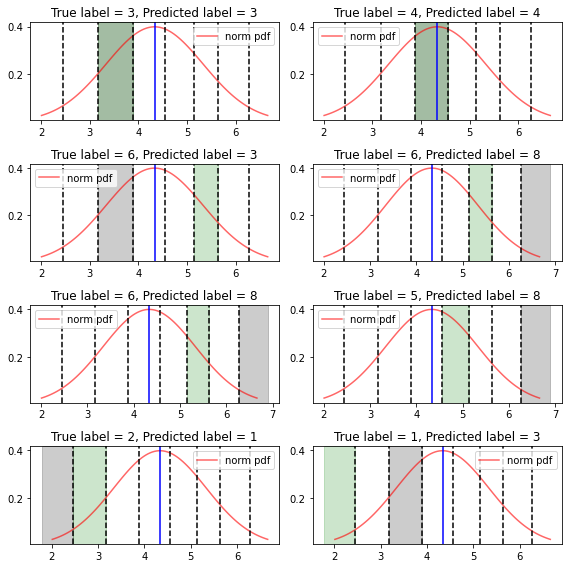

In [102]:
fig, axes = plt.subplots(4, 2, figsize=(8,8))
axes = axes.ravel()
for ax in axes:
    true_label, predicted_label = generate_result()
    x = np.linspace(norm.ppf(0.01, loc=mean_i),
                    norm.ppf(0.99, loc=mean_i), 100)
    sns.lineplot(x=x, y=norm.pdf(x, loc=mean_i),color='r', alpha=0.6, label='norm pdf', ax=ax)
    ax.axvline(mean_i, color='b')

    if thresholds[predicted_label] == np.inf:
        ax.axvspan(thresholds[predicted_label - 1], ax.get_xlim()[1], alpha=0.2, color='k')
    elif thresholds[predicted_label - 1] == -np.inf:
        ax.axvspan(ax.get_xlim()[0], thresholds[predicted_label], alpha=0.2, color='k')
    else:
        ax.axvspan(thresholds[predicted_label - 1], thresholds[predicted_label], alpha=0.2, color='k')

    if thresholds[true_label] == np.inf:
        ax.axvspan(thresholds[true_label - 1], ax.get_xlim()[1], alpha=0.2, color='g')
    elif thresholds[true_label - 1] == -np.inf:
        ax.axvspan(ax.get_xlim()[0], thresholds[true_label], alpha=0.2, color='g')
    else:
        ax.axvspan(thresholds[true_label - 1], thresholds[true_label], alpha=0.2, color='g')
    for th in thresholds:
        ax.axvline(th, 0, color='k', linestyle='--')
        
    ax.set_title(f'True label = {true_label}, Predicted label = {predicted_label}')

plt.tight_layout();

## Ranking Learning

So now we are turning to the paper by Microsoft and try to explain it a little bit. I will focus mostly on the things I found more interesting so feel free to check the paper for more information.

### Main ideas
- Learn a ranking function trained on pairs
- No mapping to particular rank boundaries
- Probabilistic cost function

Previous work main ideas:
- Ordinal regression
- PRank (parallel hyperplanes separating the various ranks)
- RankProp

### Probabilistic Ranking Cost Function
$$
\bar{P}_{AB}\\
f:R^d \mapsto R\\
f(\bf{x_1}) \geq f(\bf{x_2})
$$
### Cross entropy
$$
o_i \equiv {f(\bf{x_i})}\\
o_{ij} \equiv {f(\bf{x_i}) - f(\bf{x_j})}\\
\bar{P}_{ij} \equiv {\frac{e^{\bar{o}_{ij}}}{1 + e^{\bar{o}_{ij}}} }\\
\bar{P}_{ik} \equiv {\frac{\bar{P}_{ij} \bar{P}_{jk}}{1 + 2\bar{P}_{ij}\bar{P}_{jk} - \bar{P}_{ij} - \bar{P}_{jk}}}\\
C_{ij} \equiv C(o_{ij}) = \bar{P}_{ij} log P_{ij} - (1 - \bar{P}_{ij} log (1 - P{ij}))
$$

In [47]:
def prob_ij(distance):
    return np.exp(distance) / (1 + np.exp(distance))

def cost_function(p, p_ij):
    return -p * np.log(p_ij) - (1 - p) * np.log(1 - p_ij)

def prob_ik(p_ij, p_jk):
    return (p_ij * p_jk) / (1 + 2 * p_ij * p_jk - p_ij - p_jk)

In [44]:
distances = np.linspace(-5, 5, 100)

p0_results = cost_function(0, prob_ij(distances))
p05_results = cost_function(0.5, prob_ij(distances))
p1_results = cost_function(1, prob_ij(distances))

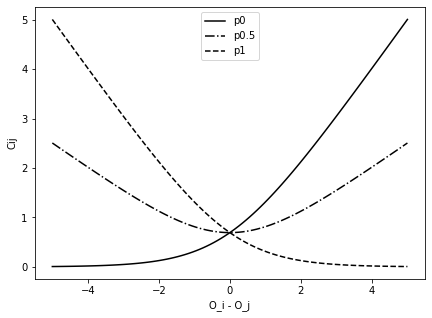

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sns.lineplot(x=distances, y=p0_results, ax=ax, color='k')
sns.lineplot(x=distances, y=p05_results, ax=ax, color='k', linestyle='-.')
sns.lineplot(x=distances, y=p1_results, ax=ax, color='k', linestyle='--')
ax.legend(labels=['p0','p0.5', 'p1'])
ax.set_xlabel('O_i - O_j')
ax.set_ylabel('Cij');

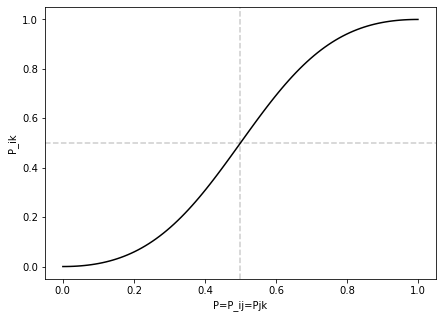

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
x = np.linspace(0, 1, 100)
sns.lineplot(x=x, y=prob_ik(x, x), ax=ax, color='k')
ax.set_xlabel('P=P_ij=Pjk')
ax.set_ylabel('P_ik')
ax.axvline(0.5, linestyle='--', color='k', alpha=0.2)
ax.axhline(0.5, linestyle='--', color='k', alpha=0.2);

### How much freedom is there to chose the pairwise probabilities?

The authors proppse a theorem that says that given a set and any permutation of it, if we have a probability specified for each adjacent pair, is necessary and sufficient to uniquely identify a target probability. 
So let's test this:

In [92]:
#from itertools import permutations

def p_to_distance(p):
    return np.log(p/(1-p))

collection = {'A', 'B', 'C', 'D', 'E'}
p = np.random.uniform(0,1,4)
p

array([0.77713275, 0.79908694, 0.33050207, 0.67320075])

In [93]:
p_to_distance(p)

array([ 1.24903487,  1.38059745, -0.70591514,  0.72269752])

permutation -> 'A', 'B', 'C', 'D', 'E'

adjacent probs -> 0.77713275, 0.79908694, 0.33050207, 0.67320075

distances -> 1.24903487,  1.38059745, -0.70591514,  0.72269752


So with this distances we can compute every distance we want for any two elements in our set. Since the distance between say first element and third element, 
then it would be $o_{AC} = o_{AB} + o_{BC} = 1.24903487 + 1.38059745 = 1.57621968$. So this way I could compute all the distances and order my set. So let's check which element goes first, B or D. We know directly that B is greater than C and C is smaller than D, so both B and D are greater than C, but which of these is bigger? Let's compute the distance between B and D and compare it to that of B and C. $o_{BD} = o_{BC} + o_{CD}$ and since we know that $O_{BC} \geq 0$ , if $o_{CD}$ is positive then $o_{BD} \geq o_{BC}$, if it is negative then $o_{BD} \leq o_{BC}$. Since $o_{CD} \leq 0$, we know that C is smaller than D, and D is smaller than B. The way I took was not optimal since we did not need to compute anything since we know that C is smaller than B and D and we have the distance between B and C and between C and D and we see that The sitance between B and C is greater than that of C and D.

As I mentioned earlier, this paper is quite old, so I do not think it is worth talking much about the architecture, I will just mention that they have a one layer network with no activations, so just a linear function and a double layer neural network. The fact that they use a one layer NN is to benchmark against other linear models. And this is actually one of the results of the paper: their linear model putperforms the other linear models due to the approach to the problem with this pair-based cost function they say. In this paper they use a neural network but of course the ranking function can be any differentiable function since is the only thing gradient descent cares about.

Conclusion